# North Carolina Litigation Predictor
# Final Preprocessing and Modeling
### Contents:
<ul>
    <li> Import Libraries
    <li> Final Preprocessing / One-Hot Encoding
    <li> Model Creation
        


## Import Libraries & Data

In [30]:
import io
import pandas as pd
import pickle

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, plot_confusion_matrix, roc_curve, auc)
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Open the dataframe
infile = open('ProjectData/df_features.data', 'rb')
df = pickle.load(infile)
infile.close()

### Review and Clean DataFrame of Unneeded Columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 9 columns):
Opinion                 2665 non-null object
SCT                     2665 non-null int64
Year_Filed              2665 non-null int64
File_Numbers            2665 non-null object
Result                  2665 non-null int64
Case_Type               2665 non-null object
Case_Type_Confidence    2665 non-null object
Trial_Judge             2665 non-null object
County                  2665 non-null object
dtypes: int64(3), object(6)
memory usage: 187.5+ KB


In [4]:
df.drop(['Opinion', 'SCT', 'File_Numbers', 'Case_Type_Confidence', 'Year_Filed'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 4 columns):
Result         2665 non-null int64
Case_Type      2665 non-null object
Trial_Judge    2665 non-null object
County         2665 non-null object
dtypes: int64(1), object(3)
memory usage: 83.4+ KB


In [6]:
df.isna().any()

Result         False
Case_Type      False
Trial_Judge    False
County         False
dtype: bool

In [7]:
df.shape

(2665, 4)

### One-Hot Encoding and Train/Test Split

In [8]:
y = df.Result
X = df.drop(columns = ['Result'])

In [9]:
# Either/Or of the following two:
X_gd = pd.get_dummies(X)
ohe = OneHotEncoder(handle_unknown='ignore')
X_ohe = ohe.fit_transform(X)

In [10]:
ohe.get_feature_names(X.columns)
# X.columns

array(['Case_Type_car_crash', 'Case_Type_construction',
       'Case_Type_contract', 'Case_Type_corporate',
       'Case_Type_defamation', 'Case_Type_employment',
       'Case_Type_estates', 'Case_Type_family_law',
       'Case_Type_fraud_udtpa', 'Case_Type_governmental',
       'Case_Type_insurance', 'Case_Type_landlord_tenant',
       'Case_Type_med_mal', 'Case_Type_other', 'Case_Type_premises',
       'Case_Type_products', 'Case_Type_property',
       'Case_Type_workers_comp', 'Case_Type_wrongful_death',
       'Trial_Judge_abernathy g.', 'Trial_Judge_abernethy richard',
       'Trial_Judge_adams gale', 'Trial_Judge_adkins karl',
       'Trial_Judge_albright', 'Trial_Judge_albright r.',
       'Trial_Judge_albright robert', 'Trial_Judge_albright stuart',
       'Trial_Judge_albright w.', 'Trial_Judge_aldridge thomas',
       'Trial_Judge_alexander karen', 'Trial_Judge_alford benjamin',
       'Trial_Judge_allen j.', 'Trial_Judge_allen philip',
       'Trial_Judge_allen stanley', 'Tr

In [11]:
X_gd.shape, X_ohe.shape

((2665, 605), (2665, 605))

In [13]:
# View class imbalance
y.value_counts()

1    1984
0     681
Name: Result, dtype: int64

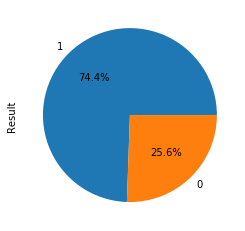

In [14]:
#Visualize class imbalance
y.value_counts().plot.pie(autopct="%.1f%%")

In [17]:
# USING X_ohe - SWITCH OUT IF DESIRED
X_train_unbalanced, X_test, y_train_unbalanced, y_test = train_test_split(X_ohe,y,random_state = 42, test_size = 0.3)

In [18]:
# sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
# X_train ,y_train = sm.fit_resample(X_train, y_train) 

indices = [i for i in range(len(X.columns))]
smnc = SMOTENC(categorical_features=indices, random_state=42, sampling_strategy='not majority')
X_train, y_train = smnc.fit_resample(X_train_unbalanced, y_train_unbalanced)

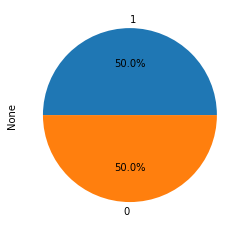

In [19]:
pd.Series(y_train).value_counts().plot.pie(autopct="%.1f%%");

In [21]:
X_train.shape, y_train.shape

((2760, 605), (2760,))

## Modeling

Some research into the best probabilistic classification models suggests that logistic regression, SVMs, and neural networks would be the best fit for the intended goal.  I will run each on the data and see which performs best. 

### Set Baseline with Dummy Classifier

In [77]:
def dummy_classifier(X_train, X_test, y_train, y_test):
    dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
    dummy_clf.fit(X_train, y_train)
    y_hat = dummy_clf.predict(X_test)
    print('Classification Report:\n', classification_report(y_test, y_hat), '\n',
          plot_confusion_matrix(dummy_clf, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
          plt.show())
    return()

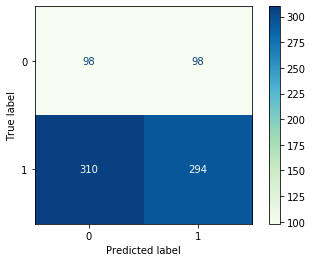

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.50      0.32       196
           1       0.75      0.49      0.59       604

    accuracy                           0.49       800
   macro avg       0.50      0.49      0.46       800
weighted avg       0.63      0.49      0.53       800
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fc714d22780> None


()

In [78]:
dummy_classifier(X_train, X_test, y_train, y_test)

### Logistic Regression Model

In [25]:
def auc_chart(fpr,tpr):
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    # Plot the ROC curve
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [71]:
def logreg_fn(X_train, X_test, y_train, y_test, params):
    logreg_clf = LogisticRegression(random_state=12)
    logreg_gs = GridSearchCV(logreg_clf, params, cv=5)
    logreg_gs.fit(X_train, y_train)
    best = logreg_gs.best_params_
    logreg_final = LogisticRegression(solver=best['solver'],
                                      penalty=best['penalty'],
                                      C=best['C'], 
                                      random_state=12)
    logreg_final.fit(X_train, y_train)
    y_hat = logreg_final.predict(X_test)
    print('Best params:',best,
          '\n\nClassification Report:\n', classification_report(y_test, y_hat), '\n',
          plot_confusion_matrix(logreg_final, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
          plt.show())
    return()

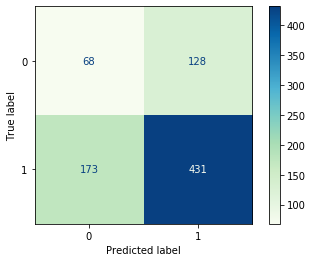

Best params: {'C': 500, 'penalty': 'none', 'solver': 'lbfgs'} 

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.35      0.31       196
           1       0.77      0.71      0.74       604

    accuracy                           0.62       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.65      0.62      0.64       800
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fc714a2b710> None


()

In [72]:
parameters = {'C':[500,100,10], 
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'solver':['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

logreg_fn(X_train, X_test, y_train, y_test, parameters)

**Dropped Year_Filed: there's no reason this should be an input, resulted in better performance time-wise, but AUC still is dismal:**<br>
Best params: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'} <br>
 Accuracy Score - Test:  0.6225 <br>
 Confusion Matrix: <br>
 [[ 59 134]<br>
 [168 439]] <br>
 AUC:  0.5017882903261602
 <br>**Predicted on Trial_Judge and Case_Type:**<br>
 Best params: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'} <br>
 Accuracy Score - Test:  0.62375 <br>
 Confusion Matrix:<br>
 [[ 54 139]<br>
 [162 445]] <br>
 AUC:  0.5018565782622427<br>
 **Predicting on Case_Type Only:**<br>
 Best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} <br>
 Accuracy Score - Test:  0.57375 <br>
 Confusion Matrix:<br>
 [[ 74 119]<br>
 [222 385]] <br>
 AUC:  0.5219631074425314<br>
 **Predicting on Trial_Judge Only:**<br>
 Best params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}  <br>
 Accuracy Score - Test:  0.56375  <br>
 Confusion Matrix: <br>
 [[ 65 128] <br>
 [221 386]]  <br>
 AUC:  0.5068586695802852 <br>

### Neural Network

In [ ]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_metrics as km

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=605, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
recall = km.binary_recall(label=0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=10)

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=10)
print('Loss: ', (results[0]),
      '\nAccuracy: ',(results[1]),
      '\nRecall: ',(results[2]))

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='middle right')
plt.show()
# "Loss"
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='middle right')
plt.show()

**Results on Test Set**

3 Dense Layers (16/8/1), 100 epochs, 0.2 validation split, batch size 10 <br>
Loss:  2.7501846364699305 <br>
Accuracy:  0.6687500029802322 <br>
Recall:  0.8162251654277773<br>
On the loss plot, the loss on the training data remains fairly constant, while the validation loss increases, indicating overfitting.  <br>

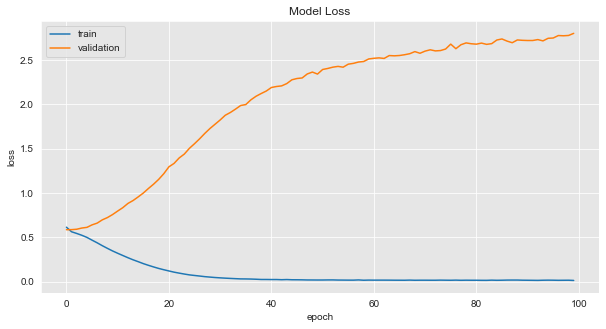


3 Dense Layers (16/8/1) with dropout(0.2), 100 epochs, 0.2 validation split, batch size 10 <br>



4 Dense Layers (2x relu) w/ Dropout(0.2) between them, 100 epochs, 0.2 validation split, batch size 10 <br>
Loss:  3.197598608955741 <br>
Accuracy:  0.6425000064074993 <br>
Recall:  0.754966887292224 <br>

3 Dense Layers (1x relu) w/ Dropout(0.2) before relu, 100 epochs, 0.2 validation split, batch size 10 <br>
Loss:  2.27144902292639 <br>
Accuracy:  0.6812500004656613 <br>
Recall:  0.8278145693993685<br>


In [ ]:
model.predict(X_test).round(3)

In [ ]:
j=model.predict_proba(X_test).round(3)

In [ ]:
import seaborn as sns
sns.distplot(j)






# create pipeline
# create dashboard